テストプログラム
目的：キャプチャボードから所望のfpsで画像を取得し、かつコマ落ちなどの異常がないか確認する。
　　　映像ソース自身、または取得時に問題があると正しくカクツキ検知できないため確認を行う。
　　　画像取得の設定値とキャプチャボードの性能確認（ベンチマーク）も行う

メモ：
- 完全GPUのみで取得するのは、現在の一般的USBカメラでは不可
　USBカメラ自体は通常 CPU経由でフレーム取得 されます。
　→ 完全にGPUで直接取得することは現状のUSBカメラAPIでは不可能（カメラドライバがGPU非対応なため）。
- できるのは CPUで取得したフレームを即GPUに転送して処理する ことです。
　差分判定、画像保存（PNG/JPEG化）、ハッシュ計算
- 

🎥 カメラスレッド設定FPS: 30
🎥 カメラスレッド設定FPS(取得値): 30.00
🎥 メインループ設定FPS: 30
[0000]   0.00 ms | FPS: 0.00 | Diff:〇 | HashSame:×
[0001]   0.00 ms | FPS: 0.00 | Diff:× | HashSame:〇
[0002]  18.90 ms | FPS:52.92 | Diff:× | HashSame:〇
[0003]   0.00 ms | FPS: 0.00 | Diff:× | HashSame:〇
[0004]   0.00 ms | FPS: 0.00 | Diff:× | HashSame:〇
[0005]   0.00 ms | FPS: 0.00 | Diff:× | HashSame:〇
[0006]   0.00 ms | FPS: 0.00 | Diff:〇 | HashSame:×
[0007]   0.00 ms | FPS: 0.00 | Diff:× | HashSame:〇
[0008]   0.00 ms | FPS: 0.00 | Diff:× | HashSame:〇
[0009]  25.63 ms | FPS:39.02 | Diff:× | HashSame:〇
[0010]  28.37 ms | FPS:35.25 | Diff:〇 | HashSame:×
[0011] 174.59 ms | FPS: 5.73 | Diff:〇 | HashSame:×
[0012]  26.20 ms | FPS:38.16 | Diff:〇 | HashSame:×
[0013]  32.57 ms | FPS:30.71 | Diff:〇 | HashSame:×
[0014]  33.42 ms | FPS:29.92 | Diff:〇 | HashSame:×
[0015]  33.26 ms | FPS:30.07 | Diff:〇 | HashSame:×
[0016]  33.21 ms | FPS:30.11 | Diff:〇 | HashSame:×
[0017]  33.33 ms | FPS:30.00 | Diff:〇 | HashSame:×
[0018]  33.61 ms |

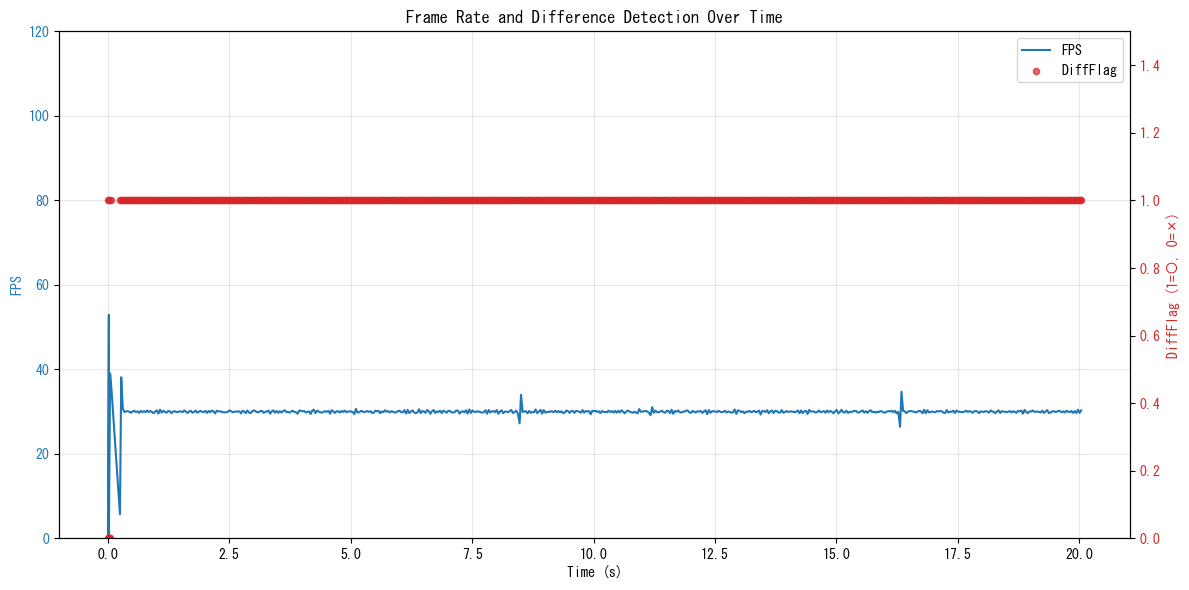

📁 グラフ保存先: C:\Users\HP_PC\Desktop\CameraCapture_GPU\2025-10-16_16-55-17\00_frame_rate_diff.jpg


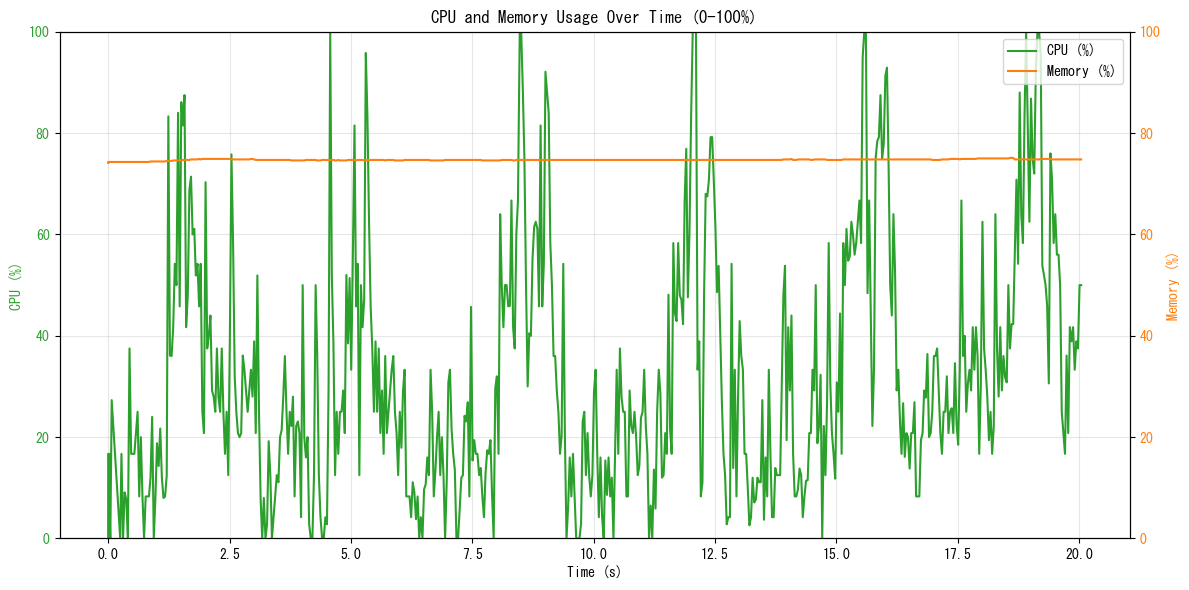

📁 CPU/メモリグラフ保存先: C:\Users\HP_PC\Desktop\CameraCapture_GPU\2025-10-16_16-55-17\00_cpu_memory_usage_fixed.jpg


In [1]:
import cv2
import threading
import time
import hashlib
import pandas as pd
import os
import cupy as cp
from datetime import datetime
from queue import Queue
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import psutil
import platform
import psutil
import GPUtil
import tkinter as tk
from tkinter import ttk

# === 日本語フォント設定 ===
plt.rcParams['font.family'] = 'MS Gothic'
plt.rcParams['axes.unicode_minus'] = False

# =========================
# 保存フォルダ作成
# =========================
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
parent_folder = os.path.join(desktop_path, "CameraCapture_GPU")
os.makedirs(parent_folder, exist_ok=True)
timestamp_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_folder = os.path.join(parent_folder, timestamp_str)
os.makedirs(save_folder, exist_ok=True)
csv_path = os.path.join(save_folder, "camera_frame_test.csv")

# =========================
# スレッドカメラクラス
# =========================
class CameraCapture:
    def __init__(self, device_number=0, width=640, height=480, fps=60): #ここの値はデフォルト値（デフォルト値は「引数を渡さなかったときの初期値」にすぎないため、メインループの引数を変えても影響しない）
        """🎥 スレッドカメラクラス（常に最新フレームを保持）"""
        self.cap = cv2.VideoCapture(device_number, cv2.CAP_MSMF)
        if not self.cap.isOpened():
            raise RuntimeError("❌ カメラを開けませんでした。")
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
        self.cap.set(cv2.CAP_PROP_FPS, thread_fps)
        self.cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

        # --- カメラが実際に設定できたFPS値を取得して保持 ---
        self.fps_set = self.cap.get(cv2.CAP_PROP_FPS)

        self.frame = None
        self.lock = threading.Lock()
        self.running = True

        self.thread = threading.Thread(target=self._update, daemon=True)
        self.thread.start()

    def _update(self):
        while self.running:
            ret, frame = self.cap.read()
            if ret:
                with self.lock:
                    self.frame = frame
            else:
                time.sleep(0.001)

    def read(self):
        with self.lock:
            return self.frame.copy() if self.frame is not None else None

    def release(self):
        self.running = False
        self.thread.join(timeout=1)
        self.cap.release()

# =========================
# GPU処理スレッド
# =========================
class GPUProcessingThread(threading.Thread):
    def __init__(self, queue, save_folder, hash_threshold=5):
        super().__init__(daemon=True)
        self.queue = queue
        self.save_folder = save_folder
        self.hash_threshold = hash_threshold
        self.records = []
        self.prev_gray_gpu = None
        self.prev_hash = None
        self.running = True

    def run(self):
        frame_id = 0
        while self.running or not self.queue.empty():
            if self.queue.empty():
                time.sleep(0.001)
                continue

            frame, timestamp = self.queue.get()

            # --- GPUに転送してグレースケール化 ---
            frame_gpu = cp.asarray(frame, dtype=cp.uint8)
            gray_gpu = cp.dot(frame_gpu[...,:3], cp.array([0.299, 0.587, 0.114], dtype=cp.float32)).astype(cp.uint8)

            # --- GPUで差分計算 ---
            if self.prev_gray_gpu is not None:
                diff_gpu = cp.abs(gray_gpu - self.prev_gray_gpu)
                diff_max = cp.max(diff_gpu).get()
                diff_flag = "〇" if diff_max > self.hash_threshold else "×"
            else:
                diff_flag = "〇"

            # --- CPU側でハッシュ計算 ---
            frame_gray_cpu = cp.asnumpy(gray_gpu)
            frame_hash = hashlib.md5(frame_gray_cpu.tobytes()).hexdigest()
            if self.prev_hash is not None:
                same_hash_flag = "〇" if frame_hash == self.prev_hash else "×"
            else:
                same_hash_flag = "×"

            # --- 画像保存 ---
            img_file = f"frame_{frame_id:04d}.jpg"
            cv2.imwrite(os.path.join(self.save_folder, img_file), frame)

            # --- CPU・メモリ使用率取得 ---
            cpu_percent = psutil.cpu_percent(interval=None)
            mem_percent = psutil.virtual_memory().percent           

            # --- 記録 ---
            interval = timestamp - (self.records[-1]["Timestamp_ms"]/1000 if self.records else timestamp)
            fps = 1.0 / interval if interval > 0 else 0.0
            self.records.append({
                "Frame": frame_id,
                "Interval_sec": interval,
                "FPS": fps,
                "DiffFlag": diff_flag,
                "SameHashFlag": same_hash_flag,
                "Timestamp_ms": timestamp*1000,
                "CPU_percent": cpu_percent,
                "Memory_percent": mem_percent,
                "ImageFile": img_file
            })

            # --- 現在値プリント ---
            print(f"[{frame_id:04d}] {interval*1000:6.2f} ms | FPS:{fps:5.2f} | Diff:{diff_flag} | HashSame:{same_hash_flag}")

            # --- 次回用 ---
            self.prev_gray_gpu = gray_gpu
            self.prev_hash = frame_hash
            frame_id += 1

# =========================
# メイン設定
# =========================
device_number = 0  # カメラデバイス番号
thread_fps = 30 # カメラスレッド設定FPS
target_fps = 15 # メインループ設定FPS
limit_frames = 120 * target_fps  # 120秒間
frame_interval = 1.0 / target_fps

# =========================
# GUI
# =========================
def apply_settings():
    global device_number, thread_fps, target_fps, frame_interval
    device_number = int(device_entry.get())
    thread_fps = int(thread_fps_slider.get())
    target_fps = int(main_fps_slider.get())
    frame_interval = 1.0 / target_fps
    root.destroy()  # GUIを閉じる

root = tk.Tk()
root.title("カメラ設定")

# デバイス番号
tk.Label(root, text="デバイス番号").grid(row=0, column=0)
device_entry = tk.Entry(root)
device_entry.insert(0, str(device_number))
device_entry.grid(row=0, column=1)

# カメラスレッドFPS
tk.Label(root, text="カメラスレッドFPS").grid(row=1, column=0)
thread_fps_slider = tk.Scale(root, from_=1, to=60, orient=tk.HORIZONTAL)
thread_fps_slider.set(thread_fps)
thread_fps_slider.grid(row=1, column=1)

# メインループFPS
tk.Label(root, text="メインループFPS").grid(row=2, column=0)
main_fps_slider = tk.Scale(root, from_=1, to=60, orient=tk.HORIZONTAL)
main_fps_slider.set(target_fps)
main_fps_slider.grid(row=2, column=1)

tk.Button(root, text="適用", command=apply_settings).grid(row=3, column=0, columnspan=2)

# GUIを表示して設定を待つ
root.mainloop()

cam = CameraCapture(device_number, fps=thread_fps)
queue = Queue(maxsize=10)
processor = GPUProcessingThread(queue, save_folder)
processor.start()

print(f"🎥 カメラスレッド設定FPS: {thread_fps}")
print(f"🎥 カメラスレッド設定FPS(取得値): {cam.fps_set:.2f}")
print(f"🎥 メインループ設定FPS: {target_fps}")

# =========================
# メインループ
# =========================
frame_id = 0
next_time = time.time()
# start_time = time.time()

try:
    while frame_id < limit_frames:
        now = time.time()
        if now < next_time:
            time.sleep(next_time - now)

        frame = cam.read()
        if frame is None:
            time.sleep(0.001)
            continue

        timestamp = time.time()
        try:
            queue.put_nowait((frame, timestamp))
        except:
            pass

        frame_id += 1
        next_time += frame_interval

except KeyboardInterrupt:
    print("⏹ 中断")

finally:
    cam.release()
    processor.running = False
    processor.join()

    # CSV保存
    df = pd.DataFrame(processor.records)
    df.to_csv(csv_path, index=False, encoding="utf-8-sig")

    # 平均FPS
    if len(processor.records) > 1:
        total_time = (processor.records[-1]["Timestamp_ms"] - processor.records[0]["Timestamp_ms"]) / 1000
        avg_fps = len(processor.records) / total_time
    else:
        avg_fps = 0.0

    # --- システム情報取得 ---
    os_info = platform.platform()
    cpu_info = platform.processor()
    memory = psutil.virtual_memory()
    mem_total_gb = memory.total / (1024 ** 3)  # GB単位

    # GPU情報（複数ある場合は1台目を使用）
    gpus = GPUtil.getGPUs()
    gpu_info = gpus[0].name if gpus else "No GPU"

    # テキスト保存
    txt_path = os.path.join(save_folder, "fps_summary.txt")
    with open(txt_path, "w", encoding="utf-8") as f:
        f.write(f"🎥 カメラスレッド設定FPS: {thread_fps:.2f}\n")
        f.write(f"🎥 カメラスレッド設定FPS（取得値）: {cam.fps_set:.2f}\n")
        f.write(f"⏱ メインループFPS: {target_fps:.2f}\n")
        f.write(f"📈 実測平均FPS: {avg_fps:.2f}\n")
        f.write("\n--- システム情報 ---\n")
        f.write(f"OS: {os_info}\n")
        f.write(f"CPU: {cpu_info}\n")
        f.write(f"メモリ合計: {mem_total_gb:.1f} GB\n")
        f.write(f"GPU: {gpu_info}\n")

    print(f"📈 実測平均FPS: {avg_fps:.2f}")
    print(f"📁 保存フォルダ: {save_folder}")
    print(f"✅ CSV保存完了 : {csv_path}")
    print(f"✅ FPSサマリー保存完了: {txt_path}")

# === CSV読み込み ===
df = pd.read_csv(csv_path)
df["Time_sec"] = (df["Timestamp_ms"] - df["Timestamp_ms"].iloc[0]) / 1000
df["DiffFlag_num"] = df["DiffFlag"].map({"〇": 1, "×": 0})

# === グラフ描画 ===
fig, ax1 = plt.subplots(figsize=(12, 6))

# --- FPSの折れ線グラフ（左軸）---
ax1.plot(df["Time_sec"], df["FPS"], color="tab:blue", label="FPS", linewidth=1.5)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("FPS", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 120)  # 縦軸固定

# --- DiffFlagを右軸で点表示 ---
ax2 = ax1.twinx()
ax2.scatter(df["Time_sec"], df["DiffFlag_num"], color="tab:red", label="DiffFlag", s=20, alpha=0.7)
ax2.set_ylabel("DiffFlag (1=〇, 0=×)", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
ax2.set_ylim(0, 1.5)  # 縦軸固定

# --- 凡例とタイトル ---
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

plt.title("Frame Rate and Difference Detection Over Time")
plt.tight_layout()

# --- JPEG保存 ---
graph_path = os.path.join(save_folder, "00_frame_rate_diff.jpg")
plt.savefig(graph_path, format="jpeg", dpi=200)
plt.show()

print(f"📁 グラフ保存先: {graph_path}")

# --- CPU/メモリ用のグラフ（縦軸固定0-100%） ---
fig2, ax1 = plt.subplots(figsize=(12, 6))

# CPU使用率（左軸）
ax1.plot(df["Time_sec"], df["CPU_percent"], color="tab:green", label="CPU (%)", linewidth=1.5)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("CPU (%)", color="tab:green")
ax1.tick_params(axis="y", labelcolor="tab:green")
ax1.set_ylim(0, 100)  # 縦軸固定
ax1.grid(True, alpha=0.3)

# メモリ使用率（右軸）
ax2 = ax1.twinx()
ax2.plot(df["Time_sec"], df["Memory_percent"], color="tab:orange", label="Memory (%)", linewidth=1.5)
ax2.set_ylabel("Memory (%)", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")
ax2.set_ylim(0, 100)  # 縦軸固定

# 凡例統合
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

plt.title("CPU and Memory Usage Over Time (0-100%)")
plt.tight_layout()

# JPEG保存
cpu_mem_graph_path = os.path.join(save_folder, "00_cpu_memory_usage_fixed.jpg")
plt.savefig(cpu_mem_graph_path, format="jpeg", dpi=200)
plt.show()

print(f"📁 CPU/メモリグラフ保存先: {cpu_mem_graph_path}")